In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import yaml 
import glob 
import pandas as pd
from burst import *

class LabelAnalysis():

    def __init__(self, video_name):
        self.video_name = video_name 
        self.__path = r'C:\Users\jyc13\Documents\Python Scripts\openCV_eyemovement\yolov5\runs\detect\{0}\labels'.format(video_name)
        self.__object_classes = yaml.safe_load(open('object_classes.yaml', 'r'))
        self.read_video_info()
        self.check_video_name()

        self.__video_w = int(self.this_info['FrameWidth']) # 가로 resolution
        self.__video_h = int(self.this_info['FrameHeight']) # 세로 resolution
        self.__video_fps = float(self.this_info['FPS']) # frame per second
        self.__start_frame = int(self.this_info['StartFrame'])
        self.__end_frame = int(self.this_info['EndFrame'])

    def read_video_info(self):
        file_path = "D:\Research\SC\DATA\Eye_Movement\VideoInfo.csv"
        self.video_info = pd.read_csv(file_path)
    
    def check_video_name(self):
        _this_info = self.video_info[self.video_info['Frequency'] == 20]
        _this_video_names = _this_info['VideoName']
        if (_this_video_names.str.contains(self.video_name).any()) == True:
            print(f"{self.video_name} is found.")
            self.this_info = self.video_info.loc[self.video_info['VideoName'] == self.video_name, :]
        else: 
            raise Exception(f"There is no file named {self.video_name}.")

    def read_labels(self):
        # YOLO style: (num_class center_x center_y w, h \n) 모든 값은 resoluion 기준으로 비율
        
        # read all txt files in the __path
        files = glob.glob(f'{self.__path}/*.txt')
        data = []
        for file in files:
            n_frame = int(file.split('_')[-1].replace('.txt', ''))
            if (n_frame >= self.__start_frame) & (n_frame <= self.__end_frame):
                with open(file, 'rt') as f:
                    lines = f.readlines()
                    for line in lines:
                        splited = line.split(' ')
                        num_class = int(splited[0])
                        class_name = str(self.__object_classes[num_class])
                        # pixel 단위로 변환
                        center_x = float(splited[1]) * self.__video_w 
                        center_y = float(splited[2]) * self.__video_h 
                        w = float(splited[3]) * self.__video_w 
                        h = float(splited[4]) * self.__video_h 
                        size = w * h # size는 width * height 직사각형이라고 가정

                        frame_data = [n_frame, num_class, class_name, center_x, center_y, w, h, size]
                        data.append(frame_data)
            else:
                pass 

        # format Dataframe
        df = pd.DataFrame(data)
        df.rename(columns = {0:'n_frame'}, inplace = True)
        df.rename(columns = {1:'num_class'}, inplace = True)
        df.rename(columns = {2:'class_name'}, inplace = True)
        df.rename(columns = {3:'center_x'}, inplace = True)
        df.rename(columns = {4:'center_y'}, inplace = True)
        df.rename(columns = {5:'width'}, inplace = True)
        df.rename(columns = {6:'height'}, inplace = True)
        df.rename(columns = {7:'size'}, inplace = True)

        df.sort_values(by=['n_frame', 'num_class'], inplace=True, ignore_index=True)

        # diff
        df['pupil-eye_x'] = df.groupby(by=['n_frame'])['center_x'].diff()
        df['pupil-eye_y'] = df.groupby(by=['n_frame'])['center_y'].diff()

        # Time code
        df['time_code'] = df['n_frame'] / self.__video_fps # return time code

        return df 
    
    def get_onoff(self):
        mouse = Burst(video_name=self.video_name)
        df_onoff = mouse.get_stim_on_frames()

        return df_onoff

    def merge_df(self):
        df_base = self.read_labels()
        df_onoff = self.get_onoff()
        df_merge = df_base.merge(df_onoff, on=['n_frame'])

        return df_merge

    def get_result_df(self):
        df_res = self.merge_df()

        return df_res
    
    def get_stim_range_list(self):
        df_res = self.merge_df()

        range_list = []
        prev_val = False

        for inx, val in df_res['stim'].iteritems():
            if prev_val != val:
                if val:
                    start = df_res.loc[inx, 'n_frame']
                else:
                    range_list.append((start, df_res.loc[inx, 'n_frame']))

            prev_val = val
            
        return range_list

In [3]:
video1_name = '60 L 20hz 5ms 5s.mp4'
mouse1 = LabelAnalysis(video_name=video1_name)

res_df = mouse1.get_result_df()
display(res_df)

60 L 20hz 5ms 5s.mp4 is found.
60 L 20hz 5ms 5s.mp4 is found.


,n_frame,num_class,class_name,center_x,center_y,width,height,size,pupil-eye_x,pupil-eye_y,time_code,stim
0,1,0,eye,910.50048,500.50008,143.000064,99.000036,14157.011484,NaN,NaN,0.016683,True
1,1,1,pupil,907.00032,506.49948,69.999936,69.000012,4829.996424,-3.50016,5.99940,0.016683,True
2,2,0,eye,914.99904,508.49964,140.000064,99.000036,13860.011376,NaN,NaN,0.033367,True
3,2,1,pupil,913.49952,514.00008,71.000064,68.000040,4828.007192,-1.49952,5.50044,0.033367,True
4,3,0,eye,921.00096,515.00016,141.999936,100.000008,14199.994736,NaN,NaN,0.050050,True
...,...,...,...,...,...,...,...,...,...,...,...,...
35403,17998,1,pupil,914.99904,529.50024,99.999936,87.000048,8699.999232,-0.50112,3.00024,300.266934,True
35404,17999,0,eye,915.99936,526.50000,141.999936,99.000036,14057.998776,NaN,NaN,300.283617,True
35405,17999,1,pupil,914.99904,530.00028,99.999936,88.000020,8799.996368,-1.00032,3.50028,300.283617,True
35406,18000,0,eye,913.00032,524.99988,138.000000,97.999956,13523.993928,NaN,NaN,300.300300,True


In [4]:
range_list = mouse1.get_stim_range_list()

60 L 20hz 5ms 5s.mp4 is found.


[(1, 175),
 (474, 773),
 (1072, 1371),
 (1670, 1969),
 (2268, 2567),
 (2866, 3165),
 (3464, 3763),
 (4062, 4361),
 (4660, 4959),
 (5258, 5557),
 (5856, 6155),
 (6454, 6753),
 (7052, 7351),
 (7650, 7949),
 (8248, 8547),
 (8846, 9145),
 (9444, 9743),
 (10042, 10341),
 (10640, 10939),
 (11238, 11537),
 (11836, 12135),
 (12434, 12733),
 (13032, 13331),
 (13630, 13929),
 (14228, 14527),
 (14826, 15125),
 (15424, 15723),
 (16022, 16321),
 (16620, 16919),
 (17218, 17517)]

In [18]:
for (start, end) in range_list:
    x_span = 180
    peth = []
    n_cycle = 0
    if start - x_span > 0 & end + x_span < max(res_df['n_frame']):
        tmp = res_df.copy()
        tmp['n_frame'] = tmp['n_frame'] - start
        tmp = tmp.loc[(tmp['n_frame'] > -x_span) & (tmp['n_frame'] < x_span), :]
        tmp['n_cycle'] = n_cycle
        n_cycle += 1
        peth.append(tmp)

df_peth = pd.concat(peth)
display(df_peth)

,n_frame,num_class,class_name,center_x,center_y,width,height,size,pupil-eye_x,pupil-eye_y,time_code,stim
33570,-179,0,eye,912.00000,525.99996,140.000064,101.999952,14279.999808,NaN,NaN,284.267601,False
33571,-179,1,pupil,917.50080,530.50032,99.000000,91.000044,9009.004356,5.50080,4.50036,284.267601,False
33572,-178,0,eye,912.00000,525.99996,140.000064,104.000004,14560.007216,NaN,NaN,284.284284,False
33573,-178,1,pupil,918.00000,530.50032,99.999936,91.000044,9099.998576,6.00000,4.50036,284.284284,False
33574,-177,0,eye,914.99904,526.50000,146.000064,103.000032,15038.011264,NaN,NaN,284.300968,False
...,...,...,...,...,...,...,...,...,...,...,...,...
34280,177,1,pupil,925.00032,532.50048,99.999936,91.000044,9099.998576,6.00000,4.00032,290.206874,True
34281,178,0,eye,914.49984,528.00012,143.000064,104.000004,14872.007228,NaN,NaN,290.223557,True
34282,178,1,pupil,925.00032,533.00052,98.000064,89.999964,8820.002232,10.50048,5.00040,290.223557,True
34283,179,0,eye,919.49952,528.50016,143.000064,104.999976,15015.003288,NaN,NaN,290.240240,True


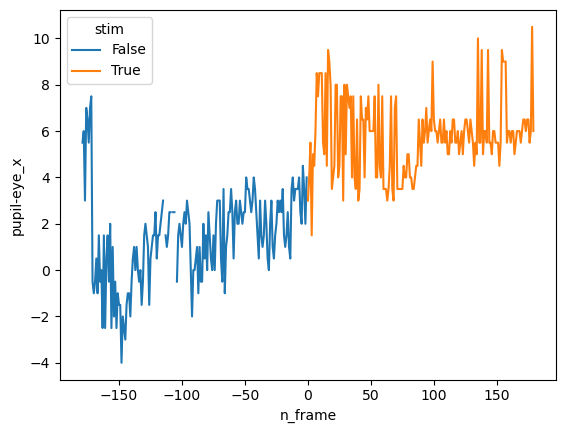

In [21]:
# PETH 
sns.lineplot(x='n_frame', y='pupil-eye_x', hue='stim', data=df_peth)
plt.show()


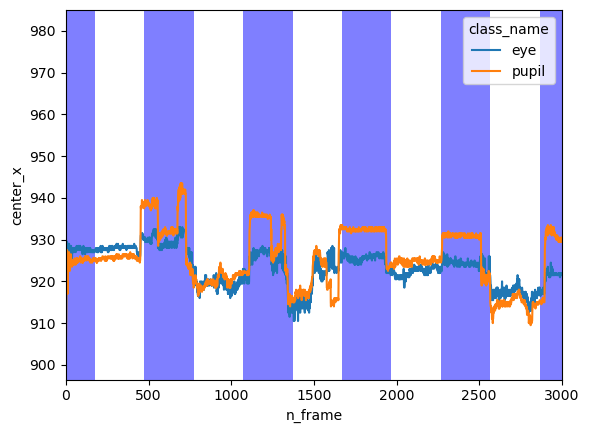

In [5]:
# x-axis
sns.lineplot(x='n_frame', y='center_x', hue='class_name', data=res_df)

for (start, end) in range_list:
    plt.axvspan(start, end, facecolor='blue', alpha=0.5)

plt.xlim(0, 3000)
plt.show()

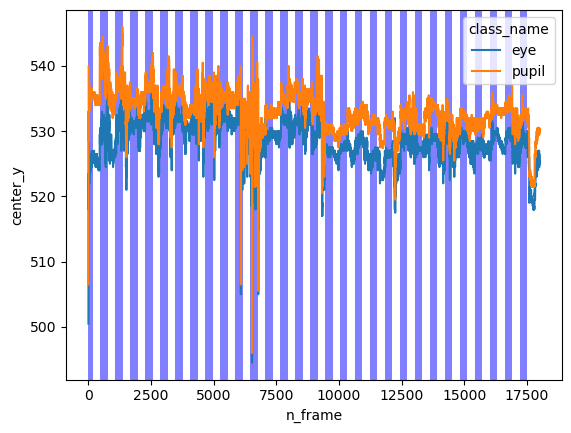

In [6]:
# y-axis
sns.lineplot(x='n_frame', y='center_y', hue='class_name', data=res_df)
for (start, end) in range_list:
    plt.axvspan(start, end, facecolor='blue', alpha=0.5)
plt.show()

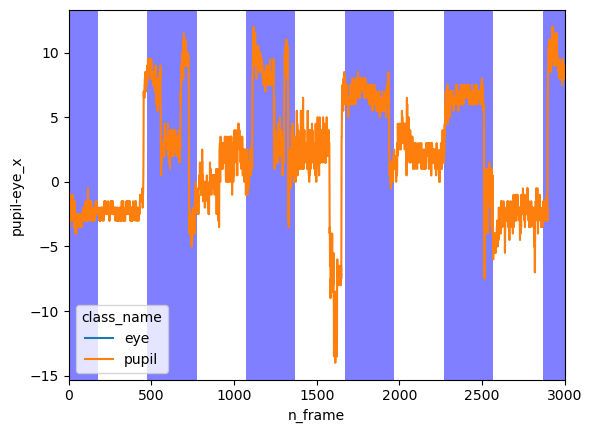

In [7]:
# diff_x
sns.lineplot(x='n_frame', y='pupil-eye_x', hue='class_name', data=res_df)
for (start, end) in range_list:
    plt.axvspan(start, end, facecolor='blue', alpha=0.5)

plt.xlim(0, 3000)
plt.show()

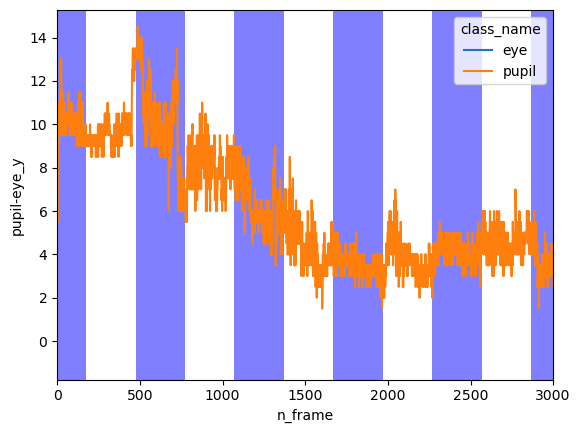

In [8]:
# diff_y
sns.lineplot(x='n_frame', y='pupil-eye_y', hue='class_name', data=res_df)
for (start, end) in range_list:
    plt.axvspan(start, end, facecolor='blue', alpha=0.5)

plt.xlim(0, 3000)
plt.show()